In [1]:
import os
import importlib.util

# Define the path to config.py
config_path = os.path.abspath(os.path.join(os.path.dirname(r'C:\Users\nilay\OneDrive - Cal State Fullerton (1)\Desktop\NILAY-TO-JOB-DATA\SPRING 2024\CPSC 597 Project\Stock-Price-Prediction'), 'Stock-Price-Prediction', 'config.py'))

# Load the module from the specified path
spec = importlib.util.spec_from_file_location("config", config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [2]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

file_path = os.path.join(config.BASE_DIR, 'dataset', 'preprocessed_data', 'AAPL.csv')
df = pd.read_csv(file_path)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# Convert date from string to datetime
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
df.dropna(axis=0, inplace=True)

# Initialize scalers for each column
scalers = {
    'Open': MinMaxScaler(),
    'High': MinMaxScaler(),
    'Low': MinMaxScaler(),
    'Close': MinMaxScaler()
}

# Scale each column separately
for column in ['Open', 'High', 'Low', 'Close']:
    df[column] = scalers[column].fit_transform(df[[column]])


c:\Users\nilay\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import pandas as pd
import numpy as np
import datetime

# Redefine str_to_datetime function to handle different date formats if needed
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Function to create a windowed dataframe
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X_open, X_high, X_low, X_close, Y_open, Y_high, Y_low, Y_close = [], [], [], [], [], [], [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        open_values = df_subset['Open'].to_numpy()
        high_values = df_subset['High'].to_numpy()
        low_values = df_subset['Low'].to_numpy()
        close_values = df_subset['Close'].to_numpy()

        X_open.append(open_values[:-1])
        Y_open.append(open_values[-1])
        
        X_high.append(high_values[:-1])
        Y_high.append(high_values[-1])
        
        X_low.append(low_values[:-1])
        Y_low.append(low_values[-1])
        
        X_close.append(close_values[:-1])
        Y_close.append(close_values[-1])

        dates.append(target_date)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    data = {
        'Target Date': dates
    }

    X_open = np.array(X_open)
    X_high = np.array(X_high)
    X_low = np.array(X_low)
    X_close = np.array(X_close)

    for i in range(n):
        data[f'Open-{n-i}'] = X_open[:, i]
        data[f'High-{n-i}'] = X_high[:, i]
        data[f'Low-{n-i}'] = X_low[:, i]
        data[f'Close-{n-i}'] = X_close[:, i]

    data['Open-Target'] = Y_open
    data['High-Target'] = Y_high
    data['Low-Target'] = Y_low
    data['Close-Target'] = Y_close

    ret_df = pd.concat({key: pd.Series(value) for key, value in data.items()}, axis=1)

    return ret_df

# Start day second time around: 1990-01-02 -- 2024-06-27
windowed_df = df_to_windowed_df(df, 
                                '2016-06-10', 
                                '2024-06-27',
                                n=5)
windowed_df


,Target Date,Open-5,High-5,Low-5,Close-5,Open-4,High-4,Low-4,Close-4,Open-3,...,Low-2,Close-2,Open-1,High-1,Low-1,Close-1,Open-Target,High-Target,Low-Target,Close-Target
0,2016-06-10,0.112153,0.111369,0.114174,0.112782,0.112383,0.115479,0.114291,0.113601,0.113831,...,0.115618,0.113959,0.112969,0.113322,0.115359,0.114778,0.113004,0.112595,0.115383,0.113832
1,2016-06-13,0.112383,0.115479,0.114291,0.113601,0.113831,0.113186,0.115946,0.114063,0.113567,...,0.115359,0.114778,0.113004,0.112595,0.115383,0.113832,0.113187,0.112334,0.113763,0.112112
2,2016-06-14,0.113831,0.113186,0.115946,0.114063,0.113567,0.112834,0.115618,0.113959,0.112969,...,0.115383,0.113832,0.113187,0.112334,0.113763,0.112112,0.111613,0.111607,0.113352,0.112251
3,2016-06-15,0.113567,0.112834,0.115618,0.113959,0.112969,0.113322,0.115359,0.114778,0.113004,...,0.113763,0.112112,0.111613,0.111607,0.113352,0.112251,0.112188,0.111528,0.113681,0.111882
4,2016-06-16,0.112969,0.113322,0.115359,0.114778,0.113004,0.112595,0.115383,0.113832,0.113187,...,0.113352,0.112251,0.112188,0.111528,0.113681,0.111882,0.110613,0.110778,0.112554,0.112355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,2024-06-21,0.986899,0.984329,0.993426,0.988782,0.982808,0.977152,0.992017,0.980704,0.980601,...,1.000000,0.989013,0.983176,0.972928,0.980512,0.967732,0.966903,0.962253,0.972341,0.957622
2021,2024-06-24,0.982808,0.977152,0.992017,0.980704,0.980601,0.994322,0.998685,1.000000,1.000000,...,0.980512,0.967732,0.966903,0.962253,0.972341,0.957622,0.954629,0.965932,0.969899,0.960622
2022,2024-06-25,0.980601,0.994322,0.998685,1.000000,1.000000,0.992869,1.000000,0.989013,0.983176,...,0.972341,0.957622,0.954629,0.965932,0.969899,0.960622,0.961203,0.959937,0.979385,0.964916
2023,2024-06-26,1.000000,0.992869,1.000000,0.989013,0.983176,0.972928,0.980512,0.967732,0.966903,...,0.969899,0.960622,0.961203,0.959937,0.979385,0.964916,0.972005,0.975744,0.988918,0.984212


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    # Extract the features (Open, High, Low, Close) from the columns
    middle_matrix = df_as_np[:, 1:-4]
    # Reshape the features matrix to include the multiple feature sets
    # Each row has n Open, High, Low, and Close values
    num_features = 4  # We have Open, High, Low, Close
    n = (middle_matrix.shape[1] // num_features)  # Number of time steps (n=3 in this case)
    X = middle_matrix.reshape((len(dates), n, num_features))

    # Extract the target values (Open-Target, High-Target, Low-Target, Close-Target)
    Y_open = df_as_np[:, -4]
    Y_high = df_as_np[:, -3]
    Y_low = df_as_np[:, -2]
    Y_close = df_as_np[:, -1]

    # Combine all target values into a single array
    Y = np.stack((Y_open, Y_high, Y_low, Y_close), axis=-1)

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2025,), (2025, 5, 4), (2025, 4))

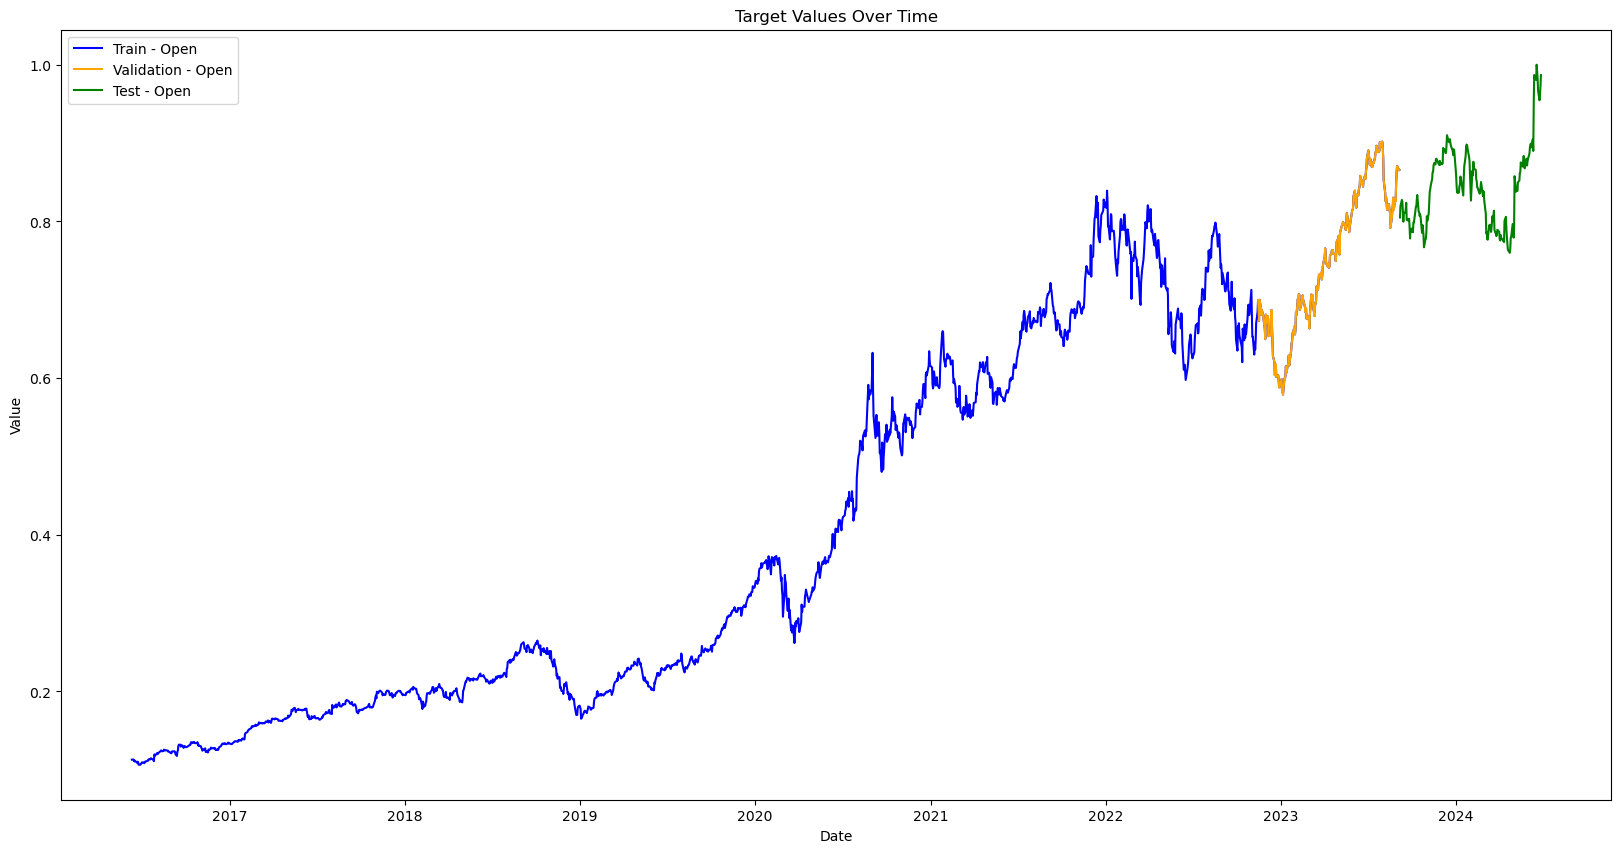

In [10]:
import matplotlib.pyplot as plt

q_80 = int(len(dates) * .80)
q_90 = int(len(dates) * .90)

dates_train2, X_train2, y_train2 = dates[:q_90], X[:q_90], y[:q_90]
dates_val2, X_val2, y_val2 = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test2, X_test2, y_test2 = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(20, 10))

# Plotting target values for each feature set
plt.plot(dates_train2, y_train2[:, 0], label='Train - Open', color='blue')
plt.plot(dates_val2, y_val2[:, 0], label='Validation - Open', color='orange')
plt.plot(dates_test2, y_test2[:, 0], label='Test - Open', color='green')

plt.legend()
plt.title('Target Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model_2 = Sequential([
    layers.Input((3, 4)),
    layers.LSTM(256),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(4)
])

# Compile the model
model_2.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Train the model with early stopping
model_2.fit(X_train2, y_train2, 
          validation_data=(X_val2, y_val2), 
          epochs=100, 
          callbacks=[early_stopping])


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.2150 - mean_absolute_error: 0.3962 - val_loss: 0.3076 - val_mean_absolute_error: 0.5261
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0833 - mean_absolute_error: 0.2149 - val_loss: 0.0016 - val_mean_absolute_error: 0.0324
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.5907e-04 - mean_absolute_error: 0.0248 - val_loss: 4.5570e-04 - val_mean_absolute_error: 0.0171
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.4732e-04 - mean_absolute_error: 0.0175 - val_loss: 4.0783e-04 - val_mean_absolute_error: 0.0155
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.8336e-04 - mean_absolute_error: 0.0158 - val_loss: 3.7471e-04 - val_mean_absolute_error: 0.0149
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.2379e-04 - mean_absolute_error: 0.0143 - val_loss: 4.0203e-04 - val_mean_absolute_error: 0.0154
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.1345e-

In [12]:
predictions = model_2.predict(X_test2)
predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


array([[0.8653816 , 0.8614114 , 0.8835745 , 0.86066175],
       [0.85890603, 0.855534  , 0.87959415, 0.8541104 ],
       [0.8508352 , 0.84764016, 0.87161994, 0.84668636],
       [0.8408202 , 0.83752275, 0.8599007 , 0.83724505],
       [0.82914764, 0.8257391 , 0.8460004 , 0.8259701 ],
       [0.81970567, 0.81627023, 0.83450985, 0.8169169 ],
       [0.8194733 , 0.81611544, 0.83494294, 0.81678474],
       [0.8162789 , 0.8129752 , 0.8315494 , 0.8137751 ],
       [0.8139635 , 0.8103541 , 0.8274222 , 0.81172234],
       [0.81406975, 0.81029785, 0.8262063 , 0.811945  ],
       [0.8156756 , 0.81203604, 0.8285883 , 0.81329525],
       [0.8164461 , 0.8129743 , 0.83053786, 0.81393   ],
       [0.8168279 , 0.81344354, 0.83172184, 0.8143625 ],
       [0.81488144, 0.8114447 , 0.82935727, 0.81258637],
       [0.8099995 , 0.80671793, 0.8245218 , 0.8077803 ],
       [0.8045746 , 0.8014439 , 0.81901157, 0.8024254 ],
       [0.8008887 , 0.79786175, 0.81556845, 0.798848  ],
       [0.79722047, 0.7941479 ,

In [13]:
# Inverse scaling the predictions
inv_predictions = {
    'Open': scalers['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1)).flatten(),
    'High': scalers['High'].inverse_transform(predictions[:, 1].reshape(-1, 1)).flatten(),
    'Low': scalers['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1)).flatten(),
    'Close': scalers['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1)).flatten()
}

# Inverse scaling the actual values
inv_y_test = {
    'Open': scalers['Open'].inverse_transform(y_test2[:, 0].reshape(-1, 1)).flatten(),
    'High': scalers['High'].inverse_transform(y_test2[:, 1].reshape(-1, 1)).flatten(),
    'Low': scalers['Low'].inverse_transform(y_test2[:, 2].reshape(-1, 1)).flatten(),
    'Close': scalers['Close'].inverse_transform(y_test2[:, 3].reshape(-1, 1)).flatten()
}

In [14]:
# Filter the dates and values for the required date range
start_date = datetime.datetime(2024, 6, 3)
end_date = datetime.datetime(2024, 6, 27)
mask = (dates_test2 >= start_date) & (dates_test2 <= end_date)

filtered_dates = dates_test2[mask]
filtered_inv_y_test = {key: value[mask] for key, value in inv_y_test.items()}
filtered_inv_predictions = {key: value[mask] for key, value in inv_predictions.items()}

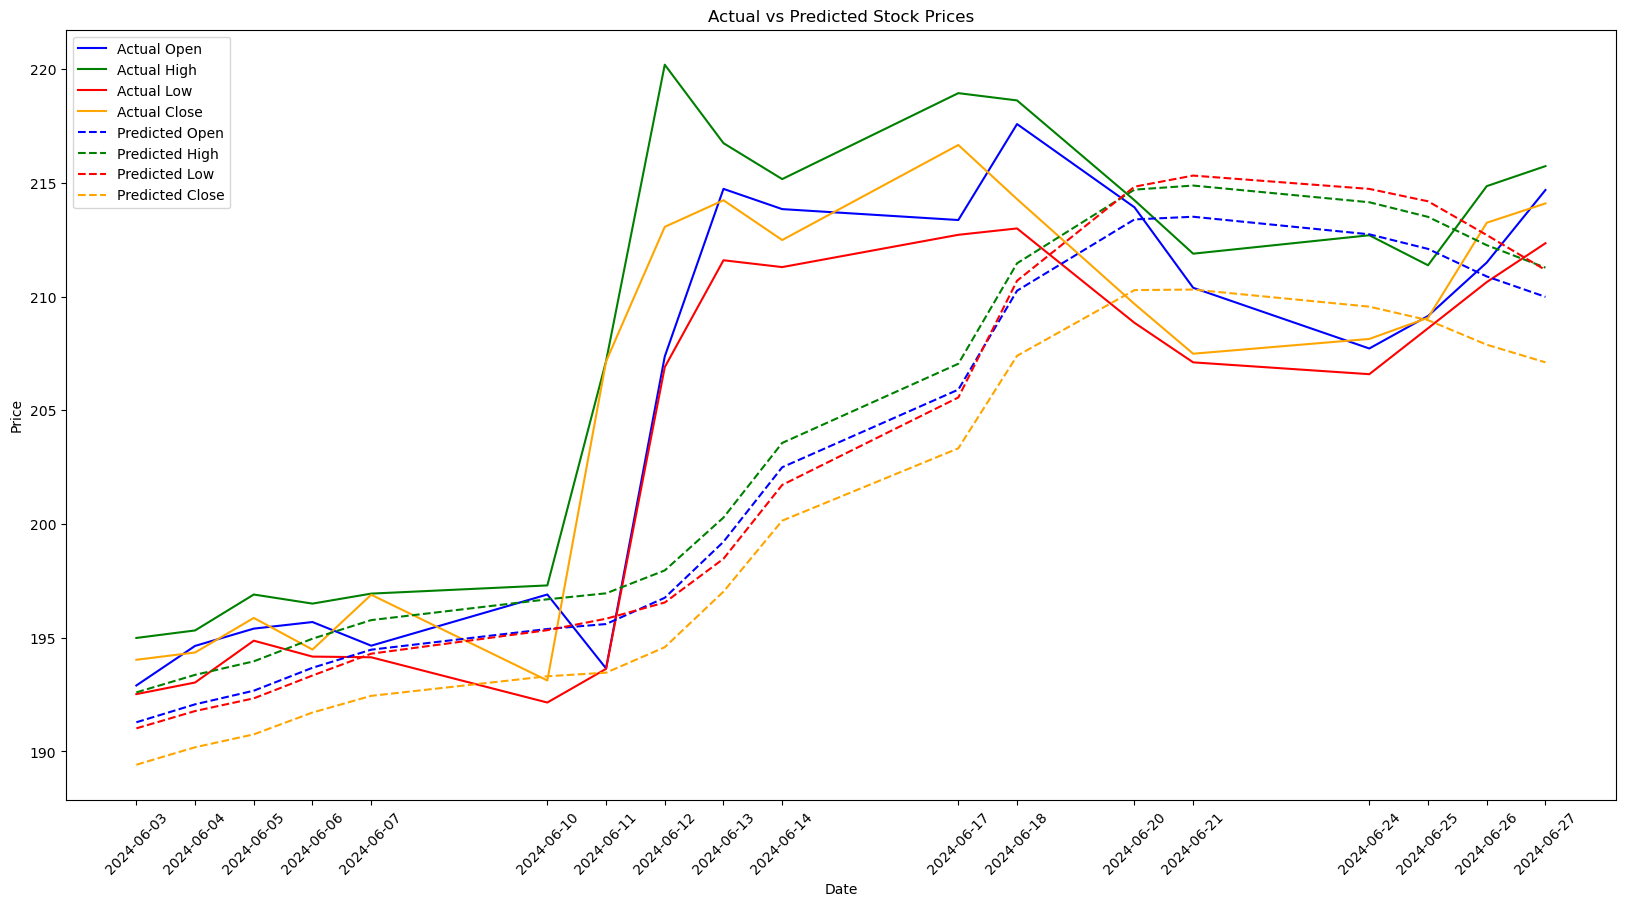

In [15]:
# Plotting
plt.figure(figsize=(20, 10))

plt.plot(filtered_dates, filtered_inv_y_test['Open'], label='Actual Open', color='blue')
plt.plot(filtered_dates, filtered_inv_y_test['High'], label='Actual High', color='green')
plt.plot(filtered_dates, filtered_inv_y_test['Low'], label='Actual Low', color='red')
plt.plot(filtered_dates, filtered_inv_y_test['Close'], label='Actual Close', color='orange')

plt.plot(filtered_dates, filtered_inv_predictions['Open'], label='Predicted Open', linestyle='--', color='blue')
plt.plot(filtered_dates, filtered_inv_predictions['High'], label='Predicted High', linestyle='--', color='green')
plt.plot(filtered_dates, filtered_inv_predictions['Low'], label='Predicted Low', linestyle='--', color='red')
plt.plot(filtered_dates, filtered_inv_predictions['Close'], label='Predicted Close', linestyle='--', color='orange')

plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Adding each date as a tick on the x-axis
plt.xticks(filtered_dates, rotation=45)
plt.show()

In [118]:
# Cell-7 (unchanged): Inverse transform the actual values for comparison
def inverse_transform(scaler, data):
    data = data.reshape(-1, 1)
    return scaler.inverse_transform(data).reshape(-1)

actual_open_prices = inverse_transform(scalers['Open'], df.loc[start_date:end_date, 'Open'].values)
actual_high_prices = inverse_transform(scalers['High'], df.loc[start_date:end_date, 'High'].values)
actual_low_prices = inverse_transform(scalers['Low'], df.loc[start_date:end_date, 'Low'].values)
actual_close_prices = inverse_transform(scalers['Close'], df.loc[start_date:end_date, 'Close'].values)

In [119]:
dates_set_future_prediction

DatetimeIndex(['2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06',
               '2024-06-07', '2024-06-10', '2024-06-11', '2024-06-12',
               '2024-06-13', '2024-06-14', '2024-06-17', '2024-06-18',
               '2024-06-20', '2024-06-21', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [120]:
actual_open_prices

array([192.899994, 194.639999, 195.399994, 195.690002, 194.649994,
       196.899994, 193.649994, 207.369995, 214.740005, 213.850006,
       213.369995, 217.589996, 213.929993, 210.389999, 207.720001,
       209.149994, 211.5     , 214.690002])

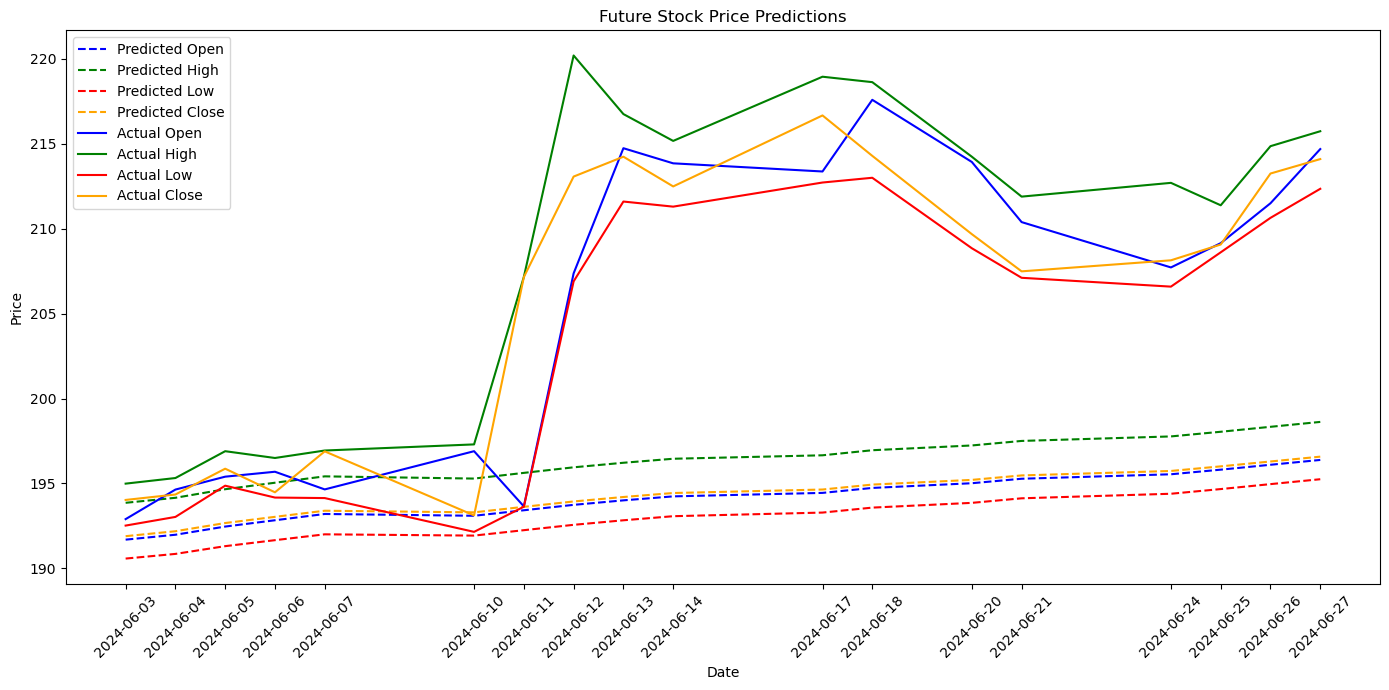

In [121]:
# Cell-8 (unchanged): Plot predicted vs actual values
import matplotlib.pyplot as plt

# Extract inverse-scaled prices
open_prices = inverse_predictions['Open']
high_prices = inverse_predictions['High']
low_prices = inverse_predictions['Low']
close_prices = inverse_predictions['Close']

plt.figure(figsize=(14, 7))

plt.plot(dates_set_future_prediction, open_prices, label='Predicted Open', color='blue', linestyle='dashed')
plt.plot(dates_set_future_prediction, high_prices, label='Predicted High', color='green', linestyle='dashed')
plt.plot(dates_set_future_prediction, low_prices, label='Predicted Low', color='red', linestyle='dashed')
plt.plot(dates_set_future_prediction, close_prices, label='Predicted Close', color='orange', linestyle='dashed')

plt.plot(dates_set_future_prediction, actual_open_prices, label='Actual Open', color='blue')
plt.plot(dates_set_future_prediction, actual_high_prices, label='Actual High', color='green')
plt.plot(dates_set_future_prediction, actual_low_prices, label='Actual Low', color='red')
plt.plot(dates_set_future_prediction, actual_close_prices, label='Actual Close', color='orange')

plt.title('Future Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(dates_set_future_prediction, rotation=45)
plt.tight_layout()
plt.show()